In the third article of the series, Using Machine Learning to Predict the Weather: Part 3, I describe how the processes and steps required to build a Neural Network using Google's TensorFlow to predict future mean daily temperatures. Using this method I can then compare the results to the Linear Regression model.

Topics I will be covering in this article include:

- Understanding Artificial Neural Networks Theory
- TensorFlow's High Level Estimator API
- Building a DNNRegressor to Predict the Weather

## Understanding Artificial Neural Networks Theory

#### En el notebook anterior he utilizado la tecnica de regresion lineal, la cual es muy util, pero rpesenta el problema de que se supone que hay una relacion lineal entre las variables a estudiar.

#### En este caso voy a utilizar redes neuronales, que se comportan bastante bien tanto cuando hay relaciones lineales como cuando no.

#### Se trata de un aprendizaje supervisado, ya el modelo se va a entrenar con informacion que ya se sabe su salida.

TODO --> poner mas informacion sobre como funciona una red neuronal

## TensorFlow's High Level Estimator API

#### TODO : explicar que es TensorFlow y como nos facilita la vida

#### En este notebook. voy a describir como usar uno de los estimadores mas potentes de redes neuronales, el `DNNRegressor`

## Construyendo un DNNRegressor para predecir el clima

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import explained_variance_score, \
    mean_absolute_error, \
    median_absolute_error
from sklearn.model_selection import train_test_split

#### ABRIMOS EL DF exportado de la segunda parte

In [2]:
import pickle
with open('end-part2_df.pkl', 'rb') as fp:
    df = pickle.load(fp)

In [5]:
# execute the describe() function and transpose the output so that it doesn't overflow the width of the screen
df.describe().T

,count,mean,std,min,25%,50%,75%,max
tmed,912.0,14.646162,7.740936,0.5,8.375,12.60,21.05,32.5
tmin,912.0,8.285965,6.953973,-5.4,2.675,7.60,13.80,24.5
tmax,912.0,21.008004,9.076888,2.6,13.500,18.90,28.85,42.2
tmed_1,912.0,14.649123,7.730972,0.5,8.400,12.60,21.05,32.5
tmed_2,912.0,14.642215,7.727721,0.5,8.400,12.60,21.05,32.5
tmed_3,912.0,14.637829,7.722571,0.5,8.375,12.60,21.05,32.5
tmin_1,912.0,8.295504,6.952217,-5.4,2.675,7.60,13.80,24.5
tmin_2,912.0,8.293860,6.950907,-5.4,2.700,7.60,13.80,24.5
tmin_3,912.0,8.294079,6.949257,-5.4,2.700,7.60,13.80,24.5
tmax_1,912.0,21.004276,9.060720,2.6,13.500,18.95,28.85,42.2


In [6]:
# execute the info() function
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 912 entries, 2018-01-04 to 2020-12-31
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tmed    912 non-null    float64
 1   tmin    912 non-null    float64
 2   tmax    912 non-null    float64
 3   tmed_1  912 non-null    float64
 4   tmed_2  912 non-null    float64
 5   tmed_3  912 non-null    float64
 6   tmin_1  912 non-null    float64
 7   tmin_2  912 non-null    float64
 8   tmin_3  912 non-null    float64
 9   tmax_1  912 non-null    float64
 10  tmax_2  912 non-null    float64
 11  tmax_3  912 non-null    float64
dtypes: float64(12)
memory usage: 92.6+ KB


#### Podemos observar que tenemos menos de 1000 filas de datos, todos son de caracter numerico y ademas no hay datos nulos o que falten. Esto se debe al preprocesado que hicimos

#### Ahora voy a eliminar tmin y tmax del dataframe ya que no tiene sentido mantenerlas para predecir la temperatura media. Estamos intentando predecir el futuro, asique no podemos tener datos del futuro, obviamente.

#### Tambien separaremos las caracteristicas del objetivo

In [7]:
# First drop the maxtempm and mintempm from the dataframe
df = df.drop(['tmin', 'tmax'], axis=1)

# X will be a pandas dataframe of all columns except meantempm
X = df[[col for col in df.columns if col != 'tmed']]

# y will be a pandas series of the meantempm
y = df['tmed']

#### Como en todas las aplicaciones supervisadas de machine learning, voy a dividir el dataset en training a testing set.

#### Por ello, para explicar mejor el proceso iterativo de entrenar esta red neuronal, voy a usar un datset adicional que sera el "validacion set". 
#### Para el entrenamiento voy a utilizar el 80% de la informacion y para testear y validar cada usare el 10% restante para cada una.

In [8]:
# split data into training set and a temporary set using sklearn.model_selection.traing_test_split
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.2, random_state=23)

In [9]:
# take the remaining 20% of data in X_tmp, y_tmp and split them evenly
X_test, X_val, y_test, y_val = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=23)

X_train.shape, X_test.shape, X_val.shape
print("Training instances   {}, Training features   {}".format(X_train.shape[0], X_train.shape[1]))
print("Validation instances {}, Validation features {}".format(X_val.shape[0], X_val.shape[1]))
print("Testing instances    {}, Testing features    {}".format(X_test.shape[0], X_test.shape[1]))

Training instances   729, Training features   9
Validation instances 92, Validation features 9
Testing instances    91, Testing features    9


#### El primer paso a dar cuando se construlle una red neuronal es instanciar la clase `tf.estimator.DNNRegressor(...)`. El constructor de esta clase tiene muchos parametros pero me voy a fijar solo en los siguientes: 
- `feature_columns`: Una lista muy parecida a una estructura que contiene la definicion del nombre y los tipos de datos que van a alimentar el modelo
- `hidden_units`: Una lista muy parecida a una estructura que contiene la definicion del numero de ancho y profundiad de la red neuronal.
- `optimizer`: Es una instanica de la subclase `tf.Optimizer`, que optimiza los pesos del modelo durante el entrenamiento. Por defecto es el optimizador AdaGrad.
- `activation_fn`: Una funcion de activacion que se usa para introducir no linealidad en la red en cada capa. Por defecto es [ReLu](https://en.wikipedia.org/wiki/Rectifier_(neural_networks))
- `model_dir`: El directorio que se creara y contendra toda la metada y los puntos de control del modelo


#### Comienzo definiendo la lista de las columnas numericas relevantes. Para hacer esto uso la funcion `tf.feature_column.numeric_column()` que me devuelve una instancia de `FeatureColumn` para caracteristicas numericas y continuas.

In [10]:
feature_cols = [tf.feature_column.numeric_column(col) for col in X.columns]

#### Ahora que ya tengo las columnas definidas, puedo instanciar la clase `DNNRegressor` y guardarla en la variable regresora. Especifico que quiero una red neuronal con dos capas profundas donde ambas capas tendran una anchura de 50 nodos. Tambien indico que la informacion de mi modelo se fuarde en un directorio llamado tf_wk_model

In [11]:
regressor = tf.estimator.DNNRegressor(feature_columns=feature_cols,
                                      hidden_units=[50, 50],
                                      model_dir='tf_wx_model')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'tf_wx_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


#### Lo siguiente cosa que quiero es definir una funcion reusable que esta generalmente referida a la "input function", que la llamare `wx_input_fn(...)`. Esta funcion sera usada para alimentar de datos mi red neuroanl durante las fases de training y testing.
#### Hay muchas maneras de construir input functions, pero yo describire como definir y usar una basada en `tf.estimator.inputs.pandas_input_fn(...)` ya que mi informacion de encuentra en una estructura de datos panda

In [12]:
def wx_input_fn(X, y=None, num_epochs=None, shuffle=True, batch_size=400):
    return tf.compat.v1.estimator.inputs.pandas_input_fn(x=X, 
                                                         y=y, 
                                                         batch_size=batch_size, 
                                                         num_epochs=num_epochs, 
                                                         shuffle=shuffle)

#### Se puede observar que la funcion `wx_input_fn(...)` toma un parametro obligatorio y 3 opcionales que los eligira tensorflow especificamente para los datos panda en la funcion que es retornada. Esta es una de las potentes caracteristicas del API de TensorFlow

#### Las parametros de la funcion se definen de la siguiente manera:
- `X` : Las features de entrada que alimentaran uno de los 3 metodos de interfaz de `DNNRegressor`, (`train`, `evaluate` y `predict`)
- `y` : Los valores objetivo de `X` que son opcionales y no seran proporcionados a la llamada de `predict`
- `num_epochs` : Parametro opcional. Una epoca ocurre cuando el ealgoritmo se ejecuta sobre todo el dataset una vez
- `shuffle` : Parametro opcional, que especifica si seleccionar de forma random una pequeña parte del dataset cada vez que el algoritmo se ejecuta
- `batch_size` : El numero de ejemplos a incluir cada vez que el algoritmo se ejecuta

#### Ahora que ya tenemos la funcion definida procedo a entrenar nuestra red neuronal con training dataset

#### Procedo a definir un simple bucle de entrenamiento para entrenar el modelo con la training data y evaluarlo periodicamente con la evaluation data

#### El bucle siguiente itera 100 veces. En el cuerpo del bucle llamo al metodo del objeto regresor `train(...)`, pasandole mi funcion reusable `wx_input_fn(...)`. 
#### He dejado adrede el `num_epochs` a None, que quiere decir que no me importa el numero de veces que pase sobre el set de entrenamiento, solamente manten el algoritmo de entrenamiento con un `batch_size` de 400, que es mas o menos la mitad del dataset. 
#### Tambien dejo el valor por defecto del parametro `shuffle`, es decir a `True` lo que significa que durante el entrenamiento, la data es seleccionada de forma aleatoria para evitar relaciones secuenciales.
#### El ultimo parametro, `steps`, que vale 400, significa que el training set va a ser procesado 400 veces por iteracion

## TODO: EXPLICAR mucho mas sobre los parametros

In [20]:
evaluations = []
STEPS = 400
for i in range(50):
    print(i)
    regressor.train(input_fn=wx_input_fn(X_train, y=y_train), steps=STEPS)
    evaluations.append(regressor.evaluate(input_fn=wx_input_fn(X_val,
                                                               y_val,
                                                               num_epochs=1,
                                                               shuffle=False)))

0
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into tf_wx_model/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 781.1291, step = 0
INFO:tensorflow:global_step/sec: 300.845
INFO:tensorflow:loss = 66.53476, step = 100 (0.334 sec)
INFO:tensorflow:global_step/sec: 361.707
INFO:tensorflow:loss = 12.359901, step = 200 (0.276 sec)
INFO:tensorflow:global_step/sec: 368.765
INFO:tensorflow:loss = 7.6182756, step = 300 (0.272 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 400...
INFO:tensorflow:Saving checkpoints for 400 into tf_wx_model/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving 

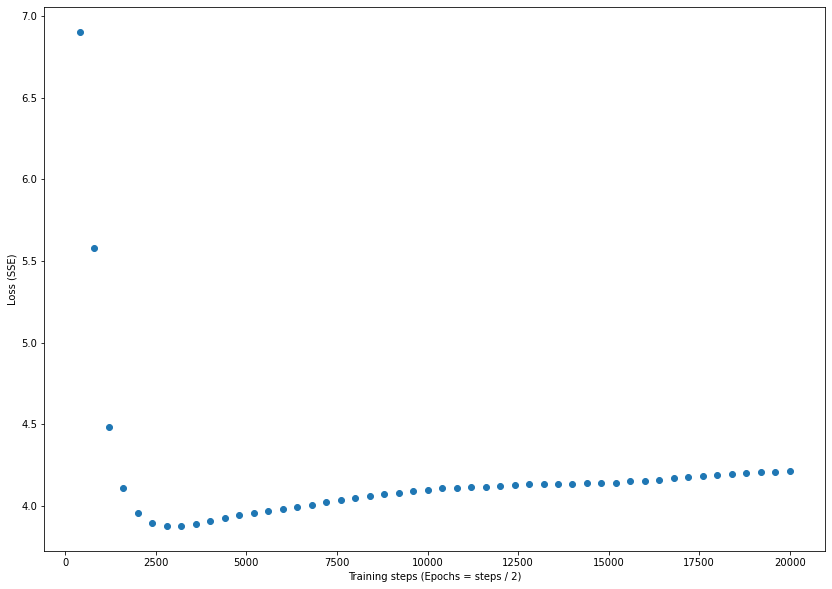

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

# manually set the parameters of the figure to and appropriate size
plt.rcParams['figure.figsize'] = [14, 10]

loss_values = [ev['loss'] for ev in evaluations]
training_steps = [ev['global_step'] for ev in evaluations]

plt.scatter(x=training_steps, y=loss_values)
plt.xlabel('Training steps (Epochs = steps / 2)')
plt.ylabel('Loss (SSE)')
plt.show()

In [22]:
pred = regressor.predict(input_fn=wx_input_fn(X_test,
                                              num_epochs=1,
                                              shuffle=False))
predictions = np.array([p['predictions'][0] for p in pred])

print("The Explained Variance: %.2f" % explained_variance_score(
                                            y_test, predictions))  
print("The Mean Absolute Error: %.2f degrees Celcius" % mean_absolute_error(
                                            y_test, predictions))  
print("The Median Absolute Error: %.2f degrees Celcius" % median_absolute_error(
                                            y_test, predictions))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-20000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
The Explained Variance: 0.95
The Mean Absolute Error: 1.47 degrees Celcius
The Median Absolute Error: 1.24 degrees Celcius
